<a href="https://colab.research.google.com/github/ancpazambuja/phd/blob/main/1semester/computer_vision/2_MultiLayerPerceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#**Visão Computacional**

## **Trabalho 3 - Implemente uma rede neural para reconhecer os dígitos da MNIST**
## **Aluno: Antonio Azambuja**

---

## **Objetivo**
O objetivo deste trabalho é explorar os detalhes da implementação de uma rede neural *Multi Layer Percéptron* (MLP). Através deste trabaho, os conceitos de aprendizado, predição, backpropagation e gradiente descendente serão fixados e entendidos. A rede não terá muita sofisticação, mas será capaz de resolver satisfatoriamente o problema de identificação de dígitos do MNIST.

---

## **O que deve ser feito**


>"
>
>Implemente uma rede neural MLP utilizando PyTorch tensors que consiga reconhecer os dígitos da base de dados MNIST. 
>
>A ideia é implementar as funções: foreward propagation, loss, backward propagation e fazer um treinamento. 
>
>O backward deve ser implementado de duas formas: 
> - implementando as expressões de cálculo dos gradiente diretamente, 
> - utilizando autograd do pytorch. 
> 
>No treinamento implemente: batch, mini-batch e estocástico.
>
>Para facilitar a avaliação do trabalho, por favor, meça e imprima:
>
> - o **tempo de treinamento**,
> - o **tempo de fazer a predição** de todo conjunto de teste,
> - o valor da **taxa de erro** (calculada como o número de todas as previsões incorretas dividido pelo número total do conjunto de dados. A melhor taxa de erro é 0, enquanto a pior é 1),
> - a **matrix de confusão**.
>
>
>Obs.: A rede neural deve ser programada por você, mas se quiser, você pode utilizar bibliotecas auxiliares do tipo sklearn.metrics para ler o dado e mostrar as métricas de resultado.
>
>"



---
##**Importando bibliotecas auxiliares**


**OBS1.:** *É necessário atualizar a biblioteca matplotlib para uma versão superior. Isso deve-se ao fato da nova versão ser necessária para algumas visualizações que serão realizadas.*

**OBS2.:** *Após o carregamento da nova versão da matplotlib, é necessário reiniciar o runtime do python.*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

import time
import torch

import matplotlib
print("")
print("Matplotlib version")
print('{}'.format(matplotlib.__version__))

!pip install matplotlib --upgrade

print("")
print("Matplotlib version")
print('{}'.format(matplotlib.__version__))


Python version
3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
Version info.
sys.version_info(major=3, minor=7, micro=15, releaselevel='final', serial=0)

Matplotlib version
3.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 317 kB/s 
     |████████████████████████████████| 965 kB 36.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2



Matplotlib version
3.2.2


---
##**Criando módulo utilitário para manipulação e visualização de imagens**

In [ ]:
class Utils:

  #definindo parametros globais
  PLOT_SX = 6 # tamanho do display em X
  PLOT_SY = 6 # tamanho do display em Y
  PLOT_FC_COLOR = 'w'  # cor de fundo branca


  #visualiza uma matriz 2d de rgb
  def drawImageRGB (img, title=''):
    plt.figure(figsize=[Utils.PLOT_SX, Utils.PLOT_SY], facecolor=Utils.PLOT_FC_COLOR)
    plt.title(title)
    plt.imshow(img)
    plt.show()


  #visualiza um atributo associado a uma escala de cores
  def drawImageAttr (img, title='', vmin=None, vmax=None, cmap="gray", colorbar=False, interpolation=None, norm=None):
    plt.figure(figsize=[Utils.PLOT_SX,Utils.PLOT_SY], facecolor=Utils.PLOT_FC_COLOR)
    plt.title(title)
    plt.imshow(img,cmap,vmin=vmin,vmax=vmax,interpolation=interpolation, norm=norm)
    if colorbar:
      plt.colorbar()
    plt.show()


  #visualiza uma matriz 2d de rgb em um eixo de subplot
  def drawImageRGB_grid(eixo, img, xlim=None, title=None, interpolation=None, aspect=None):
    eixo.set_title(title)
    eixo.imshow(img,interpolation=interpolation,aspect=aspect)
    eixo.set_xlim(xlim)


  #visualiza um atributo associado a uma escala de cores
  def drawImageAttr_grid (eixo, img, vmin=None, vmax=None, title='', cmap="gray", colorbar=False, interpolation=None, norm=None, aspect=None):
    eixo.set_title(title)
    img = eixo.imshow(img, cmap, vmin=vmin, vmax=vmax, interpolation=interpolation, norm=norm, aspect=aspect)
    if colorbar:
      plt.colorbar(img, ax=eixo)

  # Desenha o histograma de um array com controle total na geracao dos bins.
  def hist (v, bins, title="histogram"):
    plt.figure(figsize=(Utils.PLOT_SX*2,Utils.PLOT_SY))
    plt.title(title)
    n,b,p=plt.hist(v,bins)
    plt.xlim( [ bins.min(), bins.max()])
    plt.show()
    return n,b,p


  # Desenha o histograma de um array, dentro de um grid, com controle total na geracao dos bins.
  def hist_grid (eixo, v, bins, title="histogram"):
    h, b = np.histogram(v,bins)           #calcula histogram
    centers = np.zeros(h.shape[0])        # calcula o centro de cada bin
    for i,val in enumerate(bins[:-1]):
      centers[i] = (val + bins[i+1]) / 2
    eixo.set_title(title)
    #eixo.plot(centers,h)                  #desenha a funcao
    eixo.fill_between(centers,h)          #preenche a parte debaixo da curva
    eixo.set_xlim( [centers.min(), centers.max()] )
    return h,bins


  # Desenha o histograma de uma array. Os bins são gerados automaticamente a partir de v.min e v.max.
  def hist2 (v, nbins, lim, title="histogram"):
    plt.figure(figsize=(Utils.PLOT_SX*2,Utils.PLOT_SY))
    plt.title(title)

    #para forçar os limites exatos dos bins
    #n,bins,patches=plt.hist(v,nbins,range=lim)

    #para deixar os limites dos bins serem definidos a partir de v.min e v.max
    n,bins,patches=plt.hist(v,nbins)
    plt.xlim(lim)
    plt.show()
    return n,bins,patches


  def drawFunction_grid(eixo, x,ys, title=None, cores=None, fill=False, lw=None, xscale=True):

    multiplo = False 
    if ys.ndim > 1:
      multiplo = True
      fill = False    # se forem mais linhas, nao desenhar com fill

    if cores is not None:
      if multiplo:
        assert(len(cores) == ys.shape[0])
      else:
        assert(len(cores) == 1)
    else:
      if multiplo:
        cores = ["black"] * ys.shape[0]
      else:
        cores = [ "black" ]

    if not multiplo:
      linhas = np.reshape(ys, (1, ys.shape[0]))
    else:
      linhas = ys

    eixo.set_title(title)

    for l,c in list(zip(linhas,cores)):
      if fill:
        eixo.fill_between(x,l)
      else:
       eixo.plot(x, l, c, lw=lw)

    if xscale:
      eixo.set_xlim(x.min(), x.max())


  def drawFunction(x,ys, title=None, cores=None, fill=False, lw=None):

    multiplo = False 
    if ys.ndim > 1:
      multiplo = True
      fill = False    # se forem mais linhas, nao desenhar com fill

    if cores is not None:
      if multiplo:
        assert(len(cores) == ys.shape[0])
      else:
        assert(len(cores) == 1)
    else:
      if multiplo:
        cores = ["black"] * ys.shape[0]
      else:
        cores = [ "black" ]

    if not multiplo:
      linhas = np.reshape(ys, (1, ys.shape[0]))
    else:
      linhas = ys

    plt.title(title)

    for l,c in list(zip(linhas,cores)):
      if fill:
        plt.fill_between(x,l)
      else:
       plt.plot(x, l, c, lw=lw)

    plt.xlim(x.min(), x.max())


  def getMinMax(v):
    return np.min(v), np.max(v) 


  # cria uma nova imagem com a luminância
  def lum(img):
    return np.dot(img,[0.2126,0.7152,0.0722])


  def printImageInfo(img,title=None):
    if title is not None:
      print("----------- [", title, "] -------------------")
    else:
      print("------------ [ IMAGE INFO ] -------------------")
    print("[ SHAPE ]", img.shape)
    tp = img.dtype
    if img.ndim == 3:
      nc = img.shape[2]
    else:
      nc = 1
    h = img.shape[0]
    w = img.shape[1]
    print (f'[ DIMENSÕES ] w={w}, h={h}, numero de canais de cor = {nc}')
    print (f'[ CARACTERÍSTICAS ] dtype = {tp}, min={np.amin(img)}, max={np.amax(img)}, median={np.median(img)}')
    print("-----------------------------------------------")


  def printMessage(msg):
    print("---------------------------------------------------")
    print(msg)
    print("---------------------------------------------------")


  def printGPUInfo():
    iscuda       = torch.cuda.is_available()
    print(f"[ POSSUI GPGPUs? ] {iscuda}")
    if iscuda:
      device_count = torch.cuda.device_count()
      device_id    = torch.cuda.current_device()
      device_name  = torch.cuda.get_device_name(id)
      print(f"[ QUANTAS GPGPUs? ] {device_count}")
      print(f"[ ID DA GPGPU CORRENTE ] {device_id}")
      print(f"[ MODELO GPGPU ] {device_name}")



  def getTensorDevice():
    ret = 'cpu'
    iscuda       = torch.cuda.is_available()
    if iscuda:
      ret = 'cuda'
    return ret


# extracted from: https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/metrics/_classification.py#L1825
  def classification_report_2_str(data_dict):
    """Build a text report showing the main classification metrics.
    Read more in the :ref:`User Guide <classification_report>`.
    Parameters
    ----------
    report : string
        Text summary of the precision, recall, F1 score for each class.
        Dictionary returned if output_dict is True. Dictionary has the
        following structure::
            {'label 1': {'precision':0.5,
                         'recall':1.0,
                         'f1-score':0.67,
                         'support':1},
             'label 2': { ... },
              ...
            }
        The reported averages include macro average (averaging the unweighted
        mean per label), weighted average (averaging the support-weighted mean
        per label), and sample average (only for multilabel classification).
        Micro average (averaging the total true positives, false negatives and
        false positives) is only shown for multi-label or multi-class
        with a subset of classes, because it corresponds to accuracy otherwise.
        See also :func:`precision_recall_fscore_support` for more details
        on averages.
        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".
    """

    non_label_keys = ["accuracy", "macro avg", "weighted avg"]
    y_type = "binary"
    digits = 2

    target_names = [
        "%s" % key for key in data_dict.keys() if key not in non_label_keys
    ]

    # labelled micro average
    micro_is_accuracy = (y_type == "multiclass" or y_type == "binary")

    headers = ["precision", "recall", "f1-score", "support"]
    p = [data_dict[l][headers[0]] for l in target_names]
    r = [data_dict[l][headers[1]] for l in target_names]
    f1 = [data_dict[l][headers[2]] for l in target_names]
    s = [data_dict[l][headers[3]] for l in target_names]

    rows = zip(target_names, p, r, f1, s)

    if y_type.startswith("multilabel"):
        average_options = ("micro", "macro", "weighted", "samples")
    else:
        average_options = ("micro", "macro", "weighted")

    longest_last_line_heading = "weighted avg"
    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, len(longest_last_line_heading), digits)
    head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
    report = head_fmt.format("", *headers, width=width)
    report += "\n\n"
    row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    report += "\n"

    # compute all applicable averages
    for average in average_options:
        if average.startswith("micro") and micro_is_accuracy:
            line_heading = "accuracy"
        else:
            line_heading = average + " avg"

        if line_heading == "accuracy":
            avg = [data_dict[line_heading], sum(s)]
            row_fmt_accuracy = "{:>{width}s} " + \
                    " {:>9.{digits}}" * 2 + " {:>9.{digits}f}" + \
                    " {:>9}\n"
            report += row_fmt_accuracy.format(line_heading, "", "",
                                              *avg, width=width,
                                              digits=digits)
        else:
            avg = list(data_dict[line_heading].values())
            report += row_fmt.format(line_heading, *avg,
                                     width=width, digits=digits)
    return report



---
#**Rede Neural MLP**


---

##**Implementação Básica**

Serão utilizadas as implementações de referência:

 -  vídeo aula [DNN - Uma implementação de uma rede Multi Layer Perceptron, MLP](https://youtu.be/K9E9bPDKUFY) do canal ***Prof. Marcelo Gattass***;

 -  vídeo aula [DNN - Implementação de mini-batch num código de rede MLP](https://youtu.be/pzT1tXDp6xc) do canal ***Prof. Marcelo Gattass***;
 
 -  curso [Neural Networks from Scratch - Mathematics and Python Code](https://youtu.be/pauPCy_s0Ok) do canal ***The Independent Code***.




---

##**Diagramas de Classes**

Os diagramas de classes que representam as camadas é:

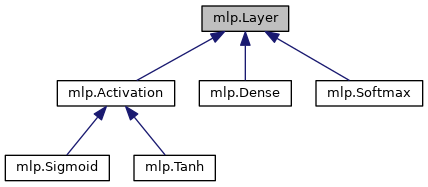


E o diagrama de classes do erro é:

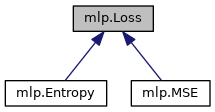

Ainda existe a classe principal:
 - Network

E outras classes auxiliares utilizadas pela Network para cálculo de métricas de erro e visualização do treinamento:
 - Report
 - ClassificationTransforms
 - Categorical


---
##**Classes - Resumo**
**Camadas básicas**
 - Base Class Layer
   - forward
   - backward
   - update
 - Derived class MLP(Layer)

**Função de Ativação** 
 - Base Class Activation(Layer)
 - Derived Class Sigmoid(Activation)

**Função de Erro a ser Minimizada** 
 - Base Class Loss
  - description
  - err
  - err_der
 - Derived Class MSE(Loss)
 - Derived Class Entropy(Loss)

**Rede**
 - Class Network
  - fit
  - predict (forward)
  - backward
  - error
  - setLearningRate
  - setEpochs




In [ ]:

#########################################################################
class Layer:

  def __init__(self, name="Default", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    self.x = None 
    self.y = None
    self.auto_grad = auto_grad
    self.name      = name
    self.verbose   = verbose
    self.device    = device


  def size(self):
    raise NotImplementedError


  def forward(self, x):
    if self.verbose:
      print(f"[ FORWARD ] layer={self.name}")
    #raise NotImplementedError


  def backward(self, y_grad, lr):
    if self.verbose:
      print(f"[ BACKWARD ] layer={self.name}")
      print(f"y_grad = ({y_grad.shape})")
      print(f"x = ({self.x.shape})")
    #raise NotImplementedError


  def update(self, lr):
    if self.verbose:
      print(f"[ UPDATE ] layer={self.name}")
      print(f"x = ({self.x.shape})")
    #raise NotImplementedError


#########################################################################
class Dense(Layer):

  def __init__(self, nx, ny, name="Dense", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    super().__init__(name=name, verbose=verbose,auto_grad=auto_grad, dtype=dtype, device=device)
    self.w = torch.randn((ny,nx), dtype=dtype, requires_grad=auto_grad, device=self.device)
    self.b = torch.randn((ny,1),  dtype=dtype, requires_grad=auto_grad, device=self.device)


  def forward(self, x):
    super().forward(x)
    #assert list(self.w.size())[-1] == list(self.x.size())[0], f"W = {self.w.size()}  - x = { self.x.size()} "
    self.x = x
    self.y = self.w @ self.x + self.b
    return self.y 


  def update(self, lr):
    super().update(lr)
    assert self.auto_grad, "O método update somente pode ser chamado quando auto_grad estiver habilitado!"
    if self.auto_grad:
        with torch.no_grad(): 
          #alterar a posição corrente em função da taxa de aprendizado e dos gradientes
          self.w -= self.w.grad * lr 
          self.b -= self.b.grad * lr
          self.w.grad.zero_()
          self.b.grad.zero_()


  def backward(self, y_grad, lr, update=True):
    super().backward(y_grad,lr)
    assert self.auto_grad == False, "Não é necessário chamar backward se auto_grad estiver"
    x_grad = self.w.t() @ y_grad
    w_grad = y_grad @ self.x.t()
    b_grad = torch.sum(y_grad,dim=1,keepdim=True)

    if update:
      self.w = self.w - w_grad*lr 
      self.b = self.b - b_grad*lr

    return x_grad 


  def size(self):
    with torch.no_grad(): 
      return self.w.shape[0]*self.w.shape[1] + self.b.shape[0]*self.b.shape[1] 


#########################################################################
class Activation(Layer):


  def __init__(self, af, af_der, verbose=False, name="Activation", auto_grad=False, device='cpu', dtype=torch.float32):
    super().__init__(name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)
    self.af = af
    self.af_der = af_der


  def forward(self, x):
    super().forward(x)
    self.x = x
    self.y = self.af(self.x)
    return self.y 


  def update(self, lr):
    return 


  def backward(self, y_grad, lr):
    super().backward(y_grad, lr)
    ret = None
    if not self.auto_grad:
      ret = y_grad * self.af_der(self.x) 
    return ret


  def size(self):
    return 0


#########################################################################
class Tanh(Activation):


  def __init__(self, name="Tanh", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    tanh = lambda x: torch.tanh(x)
    tanh_der = lambda x: 1 - torch.tanh(x)**2
    super().__init__(tanh, tanh_der,name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)



#########################################################################
class Sigmoid(Activation):

  def __init__(self, name="Sigmoid", verbose=False, auto_grad=False, device='cpu', dtype=torch.float32):
    
    def sigmoid(x):
      return 1 / (1 + torch.exp(-x))

    def sigmoid_prime(x):
      s = sigmoid(x)
      return s * (1 - s)

    super().__init__(sigmoid, sigmoid_prime, name=name, verbose=verbose, auto_grad=auto_grad, device=device, dtype=dtype)

#
#
##########################################################################
#class Softmax(Layer):
#
#  def forward(self, x):
#    self.x = x
#    xs = self.x - torch.max(self.x, dim=0,keepdim=True)  # para dar mais robustez numerica
#    tmp = torch.exp(xs)
#    self.y = torch.div(tmp,torch.sum(tmp,dim=0,keepdim=True))
#    return self.y
#    
#  def backward(self, y_grad, lr):
#    n = list(self.y.size())[0]
#    return np.dot( torch.multiply( (torch.eye(n) - self.y.t()), self.y), y_grad)



#########################################################################
class Loss:


  def __init__(self):
    pass


  def description(self):
    assert False, "Método virtual! Deve ser implementado pela classe derivada!"


  def err(self, y_true, y_pred):
    raise NotImplementedError


  def err_der(self, y_true, y_pred):
    raise NotImplementedError



#########################################################################
class MSE(Loss):


  def __init__(self):
    super().__init__()


  def description(self):
    return "Minimum Square Error"


  def err(self, y_true, y_pred):
    #print(f"shape y_true = {y_true.shape} -- shape y_pred = {y_pred.shape}")
    return torch.mean(torch.pow(y_true - y_pred, 2))


  def err_der(self, y_true, y_pred):
    #print(f"shape y_true = {y_true.shape} -- shape y_pred = {y_pred.shape}")
    return ( 2 * (y_pred - y_true) ) / list(y_true.size())[1]
    #return ( 2 * (y_pred - y_true) ) / (y_true.shape[0]*y_true.shape[1])

    #test
    #return ( 2 * (y_pred - y_true) )

class MSE_2(Loss):


  def __init__(self):
    super().__init__()


  def description(self):
    return "Minimum Square Error - 2"


  def err(self, y_true, y_pred):
    #print(f"shape y_true = {y_true.shape} -- shape y_pred = {y_pred.shape}")
    return torch.mean(torch.pow(y_true - y_pred, 2))


  def err_der(self, y_true, y_pred):
    return ( 2 * (y_pred - y_true) ) / (y_true.shape[0]*y_true.shape[1])

    #test
    #return ( 2 * (y_pred - y_true) )



#########################################################################
#class Entropy(Loss):
#
#  def __init__(self):
#    super().__init__()
#
#  def description(self):
#    return "Minimum Square Error"
#
#  def err(self, y_true, y_pred):
#    pass
#    #return torch.mean(torch.pow(y_true - y_pred, 2))
#    #return torch.pow(y_true - y_pred, 2)
#    
#  def err_der(self, y_true, y_pred):
#    pass
#    #return ( 2 * (y_pred - y_true) ) / list(y_true.size())[0]



#########################################################################
class Network:

  def __init__(self, network=None, epochs=1000, lr=0.1, loss=None, auto_grad=False, report=None, device='cpu', minibatch_size=1):
    self.epochs    = epochs
    self.lr        = lr
    self.loss      =loss
    self.network   = network
    self.auto_grad = auto_grad
    self.report    = report
    self.device    = device
    self.minibatch_size = minibatch_size

    assert self.loss is not None, "Uma medida de erro deve ser passada como parâmetro!"
    assert self.network is not None, "Uma rede deve ser passada como parãmetro!"

    for i,l in enumerate(self.network):
      assert l.auto_grad == self.auto_grad, f"Autograd da camada {i} está diferente do autograd da rede!"
      assert l.device == self.device, f"A rede está configurada para o device {self.device} e a camada {i} está para {l.device}. Não é permitido!"



  def setLearningRate(self, lr):
    self.lr = lr



  def setEpochs(self, e):
    self.epochs = e



  def __printFitInitialMessage(self, nx, ny, minibatch_size):
    Utils.printMessage("[[ INICIANDO TREINAMENTO ]]")
    print("    [ EPOCHS ]               ", self.epochs)
    print("    [ LEARNING RATE ]        ", self.lr)
    print("    [ LOSS FUNCTION ]        ", self.loss.description())
    print("    [ AUTOGRAD ]             ", self.auto_grad )
    print("    [ NÚMERO DE PARÂMETROS ] ", self.size() )
    print("    [ DEVICE ]               ", self.device )
    print("    [ X LEN ]                ", nx)
    print("    [ Y LEN ]                ", ny)
    print("    [ MINIBATCH SIZE ]       ", minibatch_size )



  def fit(self, X, Y, X_validation, Y_validation, lr=None, verbose=True, minibatch_size=None):
    """
    X, Y, X_validation e Y_validation: são numpy arrays com um batch inteiro.
    Dentro do laço das épocas esse batch inteiro será dividido em batches menores.
    """
    #assert len(X) > 0, f"Entrada X deve ter tamanho maior do que zero! X = ({len(X)})"
    #assert len(X) == len(Y), f"Entrada X e saída Y devem ter o mesmo numero de linhas! X = ({len(X)}) -- Y = ({len(Y)})"
    assert X.shape[1] == Y.shape[1], f"Minibatches de x e saída y devem ter o mesmo tamanho! X = ({X.shape[1]}) -- Y = ({Y.shape[1]})"

    if lr is not None:
      if verbose:
        Utils.printMessage(f"[ INFO ] Alterando a taxa de aprendizado de {self.lr} para {lr}.")
      self.lr = lr

    if minibatch_size is not None:
      if verbose:
        Utils.printMessage(f"[ INFO ] Alterando o tamanho do minibatch de {self.minibatch_size} para {minibatch_size}.")
      self.minibatch_size = minibatch_size


    nmb_of_minibatches = X.shape[1] // self.minibatch_size
    if X.shape[1] % self.minibatch_size != 0:
      nmb_of_minibatches += 1

    if verbose:
      self.__printFitInitialMessage(X.shape[1], Y.shape[1], self.minibatch_size)

    t_train = 0
    t_valid = 0

    shuffle = np.arange(X.shape[1]) 
    #x = torch.zeros( [ X.shape[0], self.minibatch_size ], dtype=torch.float32, device=self.device)
    #y = torch.zeros( [ Y.shape[0], self.minibatch_size ], dtype=torch.float32, device=self.device)

    #last_error = 100000
    for e in range(self.epochs):
        t0 = time.time()
        error_epoch = 0.
        dbg_error = 0.

        np.random.shuffle(shuffle)

        i_o = 0 
        while i_o < X.shape[1]:  
            i_f=min(i_o+self.minibatch_size,X.shape[1]) # o ultimo mini_batch pode ser menor
            x = torch.tensor( X[ :, shuffle[i_o:i_f] ], dtype=torch.float32, device=self.device)
            y = torch.tensor( Y[ :, shuffle[i_o:i_f] ], dtype=torch.float32, device=self.device)
            #x = torch.tensor( X[ :, shuffle[io:io+MB_LEN] ], dtype=torch.float32, device=self.device)
            #y = torch.tensor( Y[ :, shuffle[io:io+MB_LEN] ], dtype=torch.float32, device=self.device)
            #x[:,:] = X[ :, shuffle[io:io+MB_LEN] ];
            #y[:,:] = Y[ :, shuffle[io:io+MB_LEN] ];
            i_o += self.minibatch_size

            d     = self.__forward(x)
            error = self.loss.err(y,d)
            error_epoch += error

            if self.auto_grad:
               error.backward()
               self.__update()
            else:
               grad  = self.loss.err_der(y,d)
               grad  = self.__backward(grad)

        
        error_epoch /= nmb_of_minibatches
        t1 = time.time()
        t_train += (t1-t0)
        #if last_error < error.item():
        #  Utils.printMessage(f"Erro subiu. error = {error}, last_error = {last_error}")
        #  break
        #last_error = error.item() 
        accuracy = 0
        if self.report is not None:
            Y_pred = self.predict(X_validation)
            t2 = time.time()
            t_valid += (t2-t1)
            show = (e == self.epochs-1) and verbose
            accuracy = self.report.do(torch.from_numpy(Y_validation), Y_pred, e, error_epoch, show=show)

        if (e % (self.epochs//min(15,self.epochs)) == 0) and verbose:
            print(f"[ {e:5d}/{self.epochs:5d}]  [ LOSS ] {error_epoch.item():5.7f} - [ ACC ] {accuracy:5.7f} ----- [ TOTAL TIME ] train: {t_train:8.2f} secs, valid: {t_valid:8.2f} secs")

    return error_epoch.item(), accuracy, t_train


  def predict(self, X):
    return self.__forward(torch.tensor(X,dtype=torch.float32,device=self.device))



  def __forward(self, X):
    d = X
    for l in self.network:
      d = l.forward(d)
    return d


  def __update(self):
    for l in reversed(self.network):
      l.update(self.lr)


  def __backward(self, grad):
    for l in reversed(self.network):
      grad = l.backward(grad, self.lr)
    return grad



  def error(self, Y, Y_pred):
    return self.loss.err(Y,Y_pred)



  def size(self):
    n = 0
    for l in self.network:
      n += l.size()
    return n



#########################################################################
class Report:

  def __init__(self, transf=None, show=True):
    self.transf = transf
    self.show   = show
    self.yt     = None
    self.yp     = None
    self.report = [] 



  def do(self, y_true, y_pred, epoch, error, show=False):
      accuracy = self.__accuracy(y_true, y_pred, show)
      self.__confusion_matrix(y_true, y_pred, show)
      self.__addToReport(epoch, error, accuracy)
      return accuracy



  def printCurves(self):
    x = np.zeros(len(self.report), dtype=np.float32)
    y = np.zeros( [2, len(self.report)], dtype=np.float32)
    for i,l in enumerate(self.report):
      x[i] = l[0]
      y[0,i] = l[1]
      y[1,i] = l[2]
    colors=[ "b", "r"]               
    Utils.drawFunction(x, y, cores=colors)



  def __addToReport(self, epoch, error, accuracy):
    self.report.append([ epoch, error.item(), accuracy])



  def __accuracy(self, Y_true, Y_pred, show=None):
    from sklearn.metrics import classification_report

    if show is None:
      show = self.show 

    if self.transf is None:
      return

    if self.yt is None or self.yp is None:
      yt, yp = self.__buildLabels(Y_true, Y_pred) 

    output_dict = classification_report(yt, yp, output_dict=True, zero_division=0)

    if show:
      print(Utils.classification_report_2_str(output_dict))

    return output_dict["accuracy"]



  def __confusion_matrix(self, Y_true, Y_pred, show=None):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay

    if show is None:
      show = self.show 

    if not show:
      return

    if self.transf is None:
      return

    if self.yt is None or self.yp is None:
      yt, yp = self.__buildLabels(Y_true, Y_pred) 

    cm = confusion_matrix( yt, yp )
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    #print(cm)



  def __buildLabels(self, Y_true, Y_pred):
    assert Y_true.shape[1] == Y_pred.shape[1], f"Saída real e saída predita devem ter o mesmo numero de linhas! X = ({Y_true.shape[1]}) -- Y = ({Y_pred.shape[1]})"
    assert self.transf.nclasses == Y_true.shape[0], f"Numero de classes esperada nao coincide Y_true!"
    assert self.transf.nclasses == Y_pred.shape[0], f"Numero de classes esperada nao coincide com Y_pred!"

    assert self.transf is not None, "self.trans está nulo! É necessário um transformador que leva do vetor onehot para a classe!"

    tam = Y_true.shape[1]
    yt = np.zeros(tam, dtype=np.float32 )
    yp = np.zeros(tam, dtype=np.float32 )

    for i in np.arange(tam):
      yt[i] = self.transf.from_categorical(Y_true[:,i].detach().numpy())
      yp[i] = self.transf.from_categorical(Y_pred[:,i].detach().numpy())

    return yt, yp




class ClassificationTransforms:
      def __init__(self, nclasses=1):
        self.nclasses= nclasses



      def to_categorical(self, v):
        raise NotImplementedError



      def from_categorical(self, v):
        raise NotImplementedError




class Categorical(ClassificationTransforms):
      def __init__(self, nclasses=1):
        super().__init__(nclasses=nclasses)



      def to_categorical(self, v):
        return np_utils.to_categorical(v)



      def from_categorical(self, v):
        return np.argmax(v).item()






---
##**Teste do XOR**
Um teste simples de sanidade da rede pode ser a implementação da função 
$$
\displaystyle 
        xor(x_1,x_2) =  \begin{cases}
                   1, & x_1 \ne x_2 \\
                   0, & x_1 = x_2
               \end{cases};
$$

 Será proposta uma rede MLP que resolve satisfatoriamente o problema. 
 
 A arquitetura da rede segue abaixo: 

First column name    | #Neurônios
---------------------|------------------
Entrada (X)1         | 2
Camada Densa (oculta)| 3
Ativação Tanh 1      | 0
Camada Densa (saída) | 1
Ativação Tanh 2      | 0


[ POSSUI GPGPUs? ] False
---------------------------------------------------
[ INFO ] Alterando o tamanho do minibatch de 1 para 4.
---------------------------------------------------
---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                10000
    [ LEARNING RATE ]         0.1
    [ LOSS FUNCTION ]         Minimum Square Error
    [ AUTOGRAD ]              True
    [ NÚMERO DE PARÂMETROS ]  13
    [ DEVICE ]                cpu
    [ X LEN ]                 4
    [ Y LEN ]                 4
    [ MINIBATCH SIZE ]        4
[     0/10000]  [ LOSS ] 2.3820543 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.14 secs, valid:     0.00 secs
[   666/10000]  [ LOSS ] 0.0020863 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.43 secs, valid:     0.00 secs
[  1332/10000]  [ LOSS ] 0.0008946 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.61 secs, valid:     0.00 secs
[  1998/

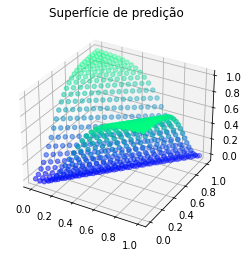

In [ ]:
def buildMLP_xor(auto_grad=False):
  verbose = False
  #criando uma rede com uma camada oculta
  layers_xor = [ 
                 Dense(2,3,verbose=verbose, auto_grad=auto_grad),
                 Tanh(verbose=verbose,      auto_grad=auto_grad),
                 Dense(3,1,verbose=verbose, auto_grad=auto_grad),
                 Tanh(verbose=verbose,      auto_grad=auto_grad),
               ]

  #report = Report(transf=Categorical(1), show=False)
  report = None
  return Network(epochs=10000, lr=0.1, loss=MSE(), network=layers_xor, auto_grad=auto_grad, report=report)




########################## [ MAIN ] ######################################
Utils.printGPUInfo()

mlp = buildMLP_xor(auto_grad=True)

X = np.array([[0,1,1,0], [0,1,0,1]], dtype=np.float32)
Y = np.array([[0,0,1,1]], dtype=np.float32)

#treinando a rede (algoritmo offline)
mlp.fit(X, Y, X, Y, minibatch_size=4)

#validando
points = []
for i in np.linspace(0, 1, 25):
    for j in np.linspace(0, 1, 25):
        y_pred = mlp.predict( np.array([[i], [j]], dtype=np.float32) )
        points.append([i, j, y_pred[0][0].detach().numpy()])

points = np.array(points)

#visualizando a superfície de predição
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.title("Superfície de predição")
plt.show()



---
##**Teste de Regressão Simples**

Outro teste de sanidade é implementar um problema simples de regressão.

Nesta seção, iremos implementar uma rede que aprenderá a função círculo abaixo definida. Esta função que distingue se um ponto está dentro ou fora de círculo de raio $R$.

$$
\displaystyle 
        circle(x_1,x_2) =  \begin{cases}
                   1, & \sqrt{x_1^2 + x_2^2} > R \\
                   0, & cc
               \end{cases}
$$

A arquitetura da rede proposta segue abaixo: 

First column name    | #Neurônios
---------------------|------------------
Entrada (X)1         | 2
Camada Densa (oculta)| 16
Ativação Tanh 1      | 0
Camada Densa (saída) | 1 
Ativação Tanh 2      | 0



---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                300
    [ LEARNING RATE ]         0.1
    [ LOSS FUNCTION ]         Minimum Square Error
    [ AUTOGRAD ]              True
    [ NÚMERO DE PARÂMETROS ]  65
    [ DEVICE ]                cpu
    [ X LEN ]                 625
    [ Y LEN ]                 625
    [ MINIBATCH SIZE ]        64
[     0/  300]  [ LOSS ] 1.9370253 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.01 secs, valid:     0.00 secs
[    20/  300]  [ LOSS ] 0.1828696 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.06 secs, valid:     0.00 secs
[    40/  300]  [ LOSS ] 0.1055762 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.11 secs, valid:     0.00 secs
[    60/  300]  [ LOSS ] 0.0898613 - [ ACC ] 0.0000000 ----- [ TOTAL TIME ] train:     0.16 secs, valid:     0.00 secs
[    80/  300]  [ LOSS ] 0.0954705 - [ ACC ] 0.0000000 ----- [ TOTAL T

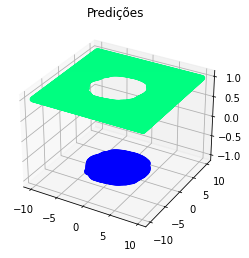

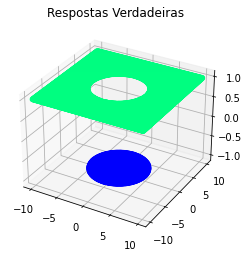

In [ ]:
def buildMLP_regressao(epochs=20000, lr=0.01, auto_grad=False):
  verbose = False
  #criando uma rede com uma camada oculta
  layers = [ 
                 Dense(2,16,verbose=verbose,auto_grad=auto_grad),
                 Tanh(verbose=verbose,auto_grad=auto_grad),
                 Dense(16,1,verbose=verbose,auto_grad=auto_grad),
                 Tanh(verbose=verbose,auto_grad=auto_grad),
               ]

  report = None
  return Network(epochs=epochs, lr=lr, loss=MSE(), network=layers,auto_grad=auto_grad, report=report, minibatch_size=64)



def geraDadosCirculo(raio=1, minibatch=1, nx1=24, nx2=24):
  from keras.utils import np_utils

  NX1=nx1
  NX2=nx2
  
  input1=np.zeros(NX1*NX2, dtype=np.float32)
  input2=np.zeros(NX1*NX2, dtype=np.float32)
  output=np.zeros(NX1*NX2, dtype=np.float32)

  X1 = np.linspace(XMIN,XMAX, NX1, dtype=np.float32)
  X2 = np.linspace(XMIN,XMAX, NX2, dtype=np.float32)

  idx=0
  for x1 in X1:
    for x2 in X2:
      input1[idx] = x1
      input2[idx] = x2

      d = np.sqrt(x1*x1 + x2*x2)
      if d > raio:
        output[idx] = -1.0
      else:
        output[idx] = 1.0
      idx = idx+1


  return np.array([ input1, input2 ], dtype=np.float32), np.array([ output ], dtype=np.float32)



########################## [ MAIN ] ######################################

XMIN=-10
XMAX=-XMIN
AUTOGRAD=True
raio = XMAX/2.

mlp = buildMLP_regressao(epochs=300, lr=0.1, auto_grad=AUTOGRAD)

X,Y = geraDadosCirculo(raio=raio, minibatch=64, nx1=25, nx2=25)


#treinando a rede (algoritmo offline)
mlp.fit(X, Y, X, Y) #OBS.: Não está sendo feita validação, pois é apenas um teste.

x = np.linspace(XMIN,XMAX,256)

points = []
for x1 in x:
  for x2 in x:
    y_pred = mlp.predict( np.array([[x1], [x2]], dtype=np.float32) )
    y_pred = -1. if y_pred[0] > 0. else 1.
    points.append([x1, x2, y_pred])
points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
#ax.scatter(X[:,0], X[:,1], Y[:], c=Y[:], cmap="winter")
plt.title("Predições")
plt.show()


points = []
for x1 in x:
  for x2 in x:
    y_pred=1
    if np.sqrt(x1*x1+x2*x2) <= raio:
      y_pred=-1
    points.append([x1, x2, y_pred])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.title("Respostas Verdadeiras")
plt.show()


##**MNIST**

A base de dados MNIST (Modified National Institute of Standards and Technology database) é uma extensa base de dados de imagens que contém os algarismos arábicos de 0 a 9 escritos à mão.

É uma base de dados padrão amplamente utilizada para avaliação de algoritmos de processamento de imagens e machine learning.

As imagens do banco de dados foram pré-processadas e reamostradas para uma dimensão fixa de 28x28 pixels com anti-álias, gerando imagens em tons de cinza, com fundo preto e o algarismo em branco.

---
###**Lendo os dados**
Será utilizada a biblioteca Keras para ler os dados.

---
###**Dados de treino, validação e teste**

A biblioteca Keras entrega os dados divididos em dados de treino e dados de teste. 

Os dados de teste são utilizados para avaliar a qualidade do classificador após todo o processo de treinamento e ajuste de hiper-parâmetros. **Os dados de teste possuem 10.000 imagens.**

Os dados de treino são utilizados para o treinamento e para a validação do laço de treinamento. Os dados de treino entregues pelo Keras possuem 60.000 imagens. Neste trabalho, estamos utilizando **50.000 para treino e 10.000 para validação**.

---
###**Visualizando os dados**
Uma grade com os 25 primeiros dados de entrada será visualizada juntamente com seus labels.

A base de dados MNIST entregue pela biblioteca Keras já se encontra bem distribuída entre suas classes e embaralhada.  

**Obs.:** Apesar da base de dados ter amostras bem distribuídas entre as classes e estar embaralhada, a rede neural aqui implementada realiza um novo embaralhamento a cada época de treinamento.

[ TEMPO ] Carregando dado: 0.3539457321166992 sec
[ INFO ] Qtd. de imagens de treino: 60000
[ INFO ] Qtd. de imagens de teste: 10000
[ INFO ] Dimensões da imagem: 28x28


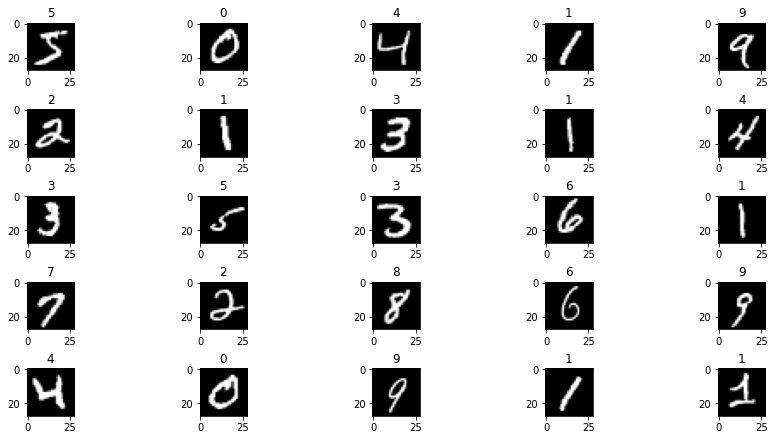

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils


# load MNIST from server

t_start = time.time()
(x_train_o_tt, y_train_o_tt), (x_test_o, y_test_o) = mnist.load_data()
t_end = time.time()
print(f"[ TEMPO ] Carregando dado: {t_end-t_start} sec")
print(f"[ INFO ] Qtd. de imagens de treino: {len(x_train_o_tt)}")
print(f"[ INFO ] Qtd. de imagens de teste: {len(x_test_o)}")
print(f"[ INFO ] Dimensões da imagem: {x_test_o.shape[1]}x{x_test_o.shape[2]}")

x_train_o = x_train_o_tt[:50000]
y_train_o = y_train_o_tt[:50000]
x_valid_o = x_train_o_tt[50000:] 
y_valid_o = y_train_o_tt[50000:] 

# visualizando os 25 primeiros dados de entrada

fig = plt.figure(figsize=(Utils.PLOT_SX*2,Utils.PLOT_SY), constrained_layout=True)
gs = fig.add_gridspec(5, 5)
for i in range(0,25):
  ax = fig.add_subplot(gs[i//5, i%5])
  Utils.drawImageAttr_grid(ax, x_train_o[i])
  ax.set_title(f"{y_train_o[i]}")
plt.show()




###**Criação da rede neural**

A proposta do trabalho é implementar uma rede neural MLP para resolver o problema de identificação de algarismos arábicos do MNIST.

É esperado que uma rede neural com uma única camada oculta, desde que tenha parâmetros suficientes, consiga gerar uma representação intermediária adequada para resolver qualquer mapeamento complexo entre a entrada e saída para diversos tipos de problema. 

Dessa forma, este trabalho analisará uma rede bastante simples com uma camada oculta apenas. 

Abaixo, segue a arquitetura da rede proposta: 

First column name    | #Neurônios
---------------------|------------------
Entrada (X)1         | 2
Camada Densa (oculta)| 40
Ativação Tanh 1      | 0
Camada Densa (saída) | 10 (onehot-encoding) 
Ativação Tanh 2      | 0

---


In [ ]:

def buildMLP_MNIST_1CamadaOculta(nw=40, epochs=1000, lr=0.01, auto_grad=False,dtype=torch.float32, show=False, report=None, device='cpu', loss=MSE() ):
  #criando uma rede com uma camada oculta
  layers = [ 
    Dense(28*28, nw, auto_grad=auto_grad, dtype=dtype, device=device),
    Tanh(auto_grad=auto_grad, dtype=dtype, device=device),
    Dense(nw, 10, auto_grad=auto_grad, dtype=dtype, device=device),
    Tanh(auto_grad=auto_grad, device=device)
    #Sigmoid(auto_grad=auto_grad, device=device)
           ]
  
  return Network(epochs=epochs, lr=lr, loss=loss, network=layers, auto_grad=auto_grad, report=report, device=device)


t_start = time.time()
mlp = buildMLP_MNIST_1CamadaOculta(nw=40, epochs=200, lr=0.01, auto_grad=True, report=None,show=False, device='cpu')#Utils.getTensorDevice())#device='cpu')
#mlp = buildMLP_MNIST_1CamadaOculta(nw=40, epochs=200, lr=0.1, auto_grad=True, report=None,show=False,device='cpu') # consegui acc = 0.91, tempo de 1500s, minibatch=4
#mlp = buildMLP_MNIST_1CamadaOculta (nw=40, epochs=200, lr=1.01, auto_grad=False, report=None,show=False, device='cpu')
t_end = time.time()
print(f"[ TEMPO ] Criando rede: {t_end-t_start} secs")

print(f"[ INFO ] A quantidade de parâmetros da rede é: { mlp.size()} ")
print(f"[ INFO ] O device utilizado é: { mlp.device} ")



[ TEMPO ] Criando rede: 0.011960983276367188 secs
[ INFO ] A quantidade de parâmetros da rede é: 31810 
[ INFO ] O device utilizado é: cpu 


---
### **Espaço de hiper-parâmetros**
Foram realizados diversos experimentos de treinamento. 

Primeiramente, foram analisados os hiper-parâmetros:
 - quantidade de épocas,
 - taxa de aprendizado,
 - tamanho do minibatch.



E, posteriormente, foram analisadas duas implementações de rede:
 - com gradiente calculado explicitamente (auto_grad=False);
 - com gradiente calculado automaticamente com o Torch.Tensor.auto_grad (auto_grad=True).

Ambas implementações utilizam o torch.Tensor como estrutura básica, então é possível utilizar facilmente GPGPUs para os testes subsequentes, quando houver disponibilidade de aceleradores.

A busca por hiper-parâmetros utilizou 27 cominações distintas dos valores abaixo descritos:


HIPER-PARÂMETRO      |  VALORES         |  TOTAL DE TESTES
---------------------|------------------|-------------
Qtd. de épocas       | 50, 100, 200     |  3
Taxa de aprendizado  | 1,0 \| 0,1 \| 0,01 | 3
Tamanho do minibatch | 4, 32, 1000      | 3
                     |                  | 27

---

####**Busca por hiper-parâmetros**

Uma vez que foi utilizada uma estratégia de força-bruta para a busca por hiper-parâmetros, o tempo de execução é um limitante importante.

Assim, a célula de código-fonte subsequente a esta foi executada e seus resultados armazenados para as análises serem realizadas posteriormente sem o risco de perda das informações da busca. 

Abaixo, seguem os resultados obtidos durante as duas execuções da busca de hiper-parâmetros: 
 - uma execução com o gradiente calculado pela função auto_grad do Pytorch.Tensor,
 - uma execução com o gradiente calculado diretamente pelo código.

Essas informações serão consolidadas visualmente na próxima seção.

**OBS.:** As execuções da busca foram realizadas apenas em CPU.


In [ ]:

def preprocess_data(x, y, limit=None, transf=Categorical(10)):

    if limit is None:
      limit = x.shape[0]


    # normalize input data
    x = x.reshape(x.shape[0], 28 * 28)
    x = x[:limit]
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    num_categories = 10
    y = transf.to_categorical(y)
    y = y.reshape(y.shape[0], num_categories)
    y = y[:limit]
    
    x=x.transpose().copy()

    y = y.transpose().copy()

    return x, y #np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)



def runTest(nepochs, lr, minibatch_size, auto_grad=True, show=False, verbose=False, device='cpu', report=Report(transf=Categorical(10))):
  print(f'[ RUN ] nepochs = {nepochs}, lr = {lr}, minibatch_size = {minibatch_size}')
  mlp = buildMLP_MNIST_1CamadaOculta(nw=40, epochs=nepochs, lr=lr, auto_grad=auto_grad, report=report,show=show, device=device)#Utils.getTensorDevice())#device='cpu')
  global x_train, y_train, x_valid, y_valid
  loss, accuracy, t_time = mlp.fit(x_train, y_train, x_valid, y_valid, lr=lr, minibatch_size=minibatch_size, verbose=verbose)
  return mlp, loss, accuracy, t_time


def runSuite(vepochs, vlr, vmini, auto_grad=True, show=False, verbose=False, device='cpu', code=True, report=Report(transf=Categorical(10))):

    results = {}
    print(f"[ INFO ] Qtd. de testes: {vepochs.shape[0]*vlr.shape[0]*vmini.shape[0]}")
    
    t_start = time.time()
    
    best_accuracy=None
    cont=0
    for i,e in enumerate(vepochs):
      results[e] = {}
      for j,l in enumerate(vlr):
        results[e][l] = {}
        for k,m in enumerate(vmini):
    
          mlp, loss, accuracy, t_time = runTest(e,l,m,auto_grad=auto_grad, show=show, verbose=verbose, device=device, report=report) 
    
          if best_accuracy is None or accuracy > best_accuracy["acc"]:
            best_accuracy = { 
                'loss': loss, 'acc': accuracy, 'tempo':t_time,
                'epoch':e, 'lr': l, 'mini':m
            }
            print("[ BEST ACCURACY ] ", best_accuracy)
    
          results[e][l][m] = [loss, accuracy, t_time]
          print(f"[ {cont} ] loss={loss}, acc={accuracy}, tempo treinamento={t_time} secs")
          if code:
            print(f"[ CODE ] e = {e}; l = {l}; m = {m}")
            print(f"[ CODE ] insere_elemento(tab_resultados, e=e, l=l, m=m, loss={loss}, acc={accuracy}, tempo={t_time})" )
          cont  = cont + 1
    
    t_end = time.time()
    print("[ BEST ACCURACY ] ", best_accuracy)
    print("[ TOTAL TIME ] ", t_end-t_start, " secs")

    return results



#################################################################3


DTYPE=torch.float32
transf = Categorical(10)

t_start = time.time()
x_train, y_train  = preprocess_data(x_train_o, y_train_o, limit=50000, transf=transf)
x_valid, y_valid = preprocess_data(x_valid_o, y_valid_o, limit=10000, transf=transf) #observacao: para o dado de teste, somente está funcionando minibatch=1
x_test, y_test = preprocess_data(x_test_o, y_test_o, limit=10000, transf=transf) #observacao: para o dado de teste, somente está funcionando minibatch=1
t_end = time.time()
print(f"[ TEMPO ] Preprocessando o dado: {t_end-t_start} secs")




[ TEMPO ] Preprocessando o dado: 0.2996652126312256 secs


In [ ]:
# OBSERVAÇÃO:
#
# Esta célula implementa a busca por hiper-parâmetros.
# Sua execução durou um pouco mais de 6 horas no total, mas foi interrompida diversas vezes.
# Por isso, os resultados parciais eram salvos a cada teste realizado.
#

vepochs=np.array([50, 100, 200])
vlr=np.array([1., 0.1, 0.01] )
vmini=np.array([4, 32, 1000])


runSuite(vepochs, vlr, vmini, auto_grad=True, show=False, verbose=False, device='cpu', code=True)

print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")

runSuite(vepochs, vlr, vmini, auto_grad=False, show=False, verbose=False, device='cpu', code=True)



---------------------------------------------------------------
---------------------------------------------------------------
---------------------------------------------------------------
[ INFO ] Qtd. de testes: 9
[ RUN ] nepochs = 50, lr = 0.001, minibatch_size = 4
[ BEST ACCURACY ]  {'loss': 0.049198564141988754, 'acc': 0.721, 'tempo': 335.61078333854675, 'epoch': 50, 'lr': 0.001, 'mini': 4}
[ 0 ] loss=0.049198564141988754, acc=0.721, tempo treinamento=335.61078333854675 secs
[ CODE ] e = 50; l = 0.001; m = 4
[ CODE ] insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.049198564141988754, acc=0.721, tempo=335.61078333854675
[ RUN ] nepochs = 50, lr = 0.001, minibatch_size = 32
[ 1 ] loss=0.12329500913619995, acc=0.4144, tempo treinamento=77.53619408607483 secs
[ CODE ] e = 50; l = 0.001; m = 32
[ CODE ] insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.12329500913619995, acc=0.4144, tempo=77.53619408607483
[ RUN ] nepochs = 50, lr = 0.001, minibatch_size = 1000
[ 2 ] loss=

{50: {0.001: {4: [0.049198564141988754, 0.721, 335.61078333854675],
   32: [0.12329500913619995, 0.4144, 77.53619408607483],
   1000: [0.9474769830703735, 0.1304, 45.96830725669861]}},
 100: {0.001: {4: [0.04408295452594757, 0.7797, 657.6447465419769],
   32: [0.07165167480707169, 0.5343, 157.13096714019775],
   1000: [0.8456923365592957, 0.1352, 92.80142307281494]}},
 200: {0.001: {4: [0.030237995088100433, 0.8467, 1334.9995057582855],
   32: [0.061428748071193695, 0.6587, 308.7629382610321],
   1000: [0.7855963110923767, 0.1754, 184.9287121295929]}}}

---
####**Análise da busca de hiper-parâmetros**

Esta seção busca analisar os resultados da busca por hiper-parâmetros.



---
#####**Restaurando os resultados da busca**

A execução da busca, além de armazenar suas informações em memória, também gera um código python (o próprio código da célula de código abaixo) que permite regerar as informações em qualquer momento futuro, sem ter que executar a busca novamente. O código é apropriado para o caso da busca ter sido interrompida no meio do processamento.

In [ ]:
def insere_elemento(tab, e=None, l=None, m=None, loss=None, acc=None, tempo=None):
  if e not in tab:
    tab[e] = {}
  if l not in tab[e]:
    tab[e][l] = {}

  assert m not in tab[e][l], f"Erro interno de lógica! m {m} já foi inserido na posição {e}, {l}!"
  if m not in tab[e][l]:
    tab[e][l][m] = { "loss":loss, "acc":acc, "tempo":tempo}
  

In [ ]:

tab_resultados = {}

e = 50; l = 1.0; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.2557094097137451, acc=0.7061, tempo=408.1818244457245)

e = 50; l = 1.0; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.26952579617500305, acc=0.6964, tempo=87.70835304260254)

e = 50; l = 1.0; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.2936631739139557, acc=0.6166, tempo=46.84210991859436)

e = 50; l = 0.1; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.02673804759979248, acc=0.8777, tempo=406.33709621429443)

e = 50; l = 0.1; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.04722844809293747, acc=0.7219, tempo=87.7988691329956)

e = 50; l = 0.1; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.7452626824378967, acc=0.2758, tempo=47.23520088195801)

e = 50; l = 0.01; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.04918183013796806, acc=0.7317, tempo=405.063428401947)

e = 50; l = 0.01; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.08621035516262054, acc=0.5091, tempo=87.65486574172974)

e = 50; l = 0.01; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.9124515652656555, acc=0.0965, tempo=47.34242105484009)

e = 100; l = 1.0; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.2161237895488739, acc=0.8492, tempo=811.896665096283)

e = 100; l = 1.0; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.1523572951555252, acc=0.7312, tempo=174.65659999847412)

e = 100; l = 1.0; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.29226547479629517, acc=0.3387, tempo=93.42555713653564)

e = 100; l = 0.1; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.022310176864266396, acc=0.9017, tempo=813.7840504646301)

e = 100; l = 0.1; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.04257277771830559, acc=0.8142, tempo=175.21407842636108)

e = 100; l = 0.1; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.2181880921125412, acc=0.2137, tempo=92.52679491043091)

e = 100; l = 0.01; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.03946641832590103, acc=0.7941, tempo=811.1305551528931)

e = 100; l = 0.01; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.0732012465596199, acc=0.5307, tempo=175.26577997207642)

e = 100; l = 0.01; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.8554050326347351, acc=0.1501, tempo=92.49700117111206)

e = 200; l = 1.0; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.17732222378253937, acc=0.7807, tempo=991.5916571617126)

e = 200; l = 1.0; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.1637067198753357, acc=0.7364, tempo=239.44796776771545)

e = 200; l = 1.0; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.22424353659152985, acc=0.5537, tempo=137.01729726791382)

e = 200; l = 0.1; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.022677160799503326, acc=0.9066, tempo=992.0421960353851)

e = 200; l = 0.1; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.03529036045074463, acc=0.832, tempo=241.54492092132568)

e = 200; l = 0.1; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.08363032341003418, acc=0.5343, tempo=136.37414073944092)

e = 200; l = 0.01; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.028381995856761932, acc=0.8517, tempo=985.1729094982147)

e = 200; l = 0.01; m = 32
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.06407766789197922, acc=0.5027, tempo=240.0299413204193)

e = 200; l = 0.01; m = 1000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.7989704608917236, acc=0.119, tempo=136.4572343826294)


In [ ]:
tab_resultados_sem_auto_grad = {}

e = 50; l = 1.0; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.9001117944717407, acc=0.098, tempo=235.0191605091095)

e = 50; l = 1.0; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.41665005683898926, acc=0.5967, tempo=62.8063862323761)

e = 50; l = 1.0; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.30339744687080383, acc=0.6403, tempo=40.595623254776)

e = 50; l = 0.1; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.22264543175697327, acc=0.7687, tempo=234.4763367176056)

e = 50; l = 0.1; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.16650669276714325, acc=0.6507, tempo=62.55232214927673)

e = 50; l = 0.1; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.3171577453613281, acc=0.4112, tempo=40.68881845474243)

e = 50; l = 0.01; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.029226059094071388, acc=0.8696, tempo=233.9167881011963)


e = 50; l = 0.01; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.047875866293907166, acc=0.7545, tempo=62.13549852371216)

e = 50; l = 0.01; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.7183678150177002, acc=0.2268, tempo=40.55301284790039)

e = 100; l = 1.0; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.9001117944717407, acc=0.098, tempo=466.5323429107666)

e = 100; l = 1.0; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.4574606120586395, acc=0.5204, tempo=124.66898918151855)

e = 100; l = 1.0; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.2943468987941742, acc=0.6312, tempo=81.91157817840576)

e = 100; l = 0.1; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.13590118288993835, acc=0.6325, tempo=466.9936294555664)

e = 100; l = 0.1; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.24596500396728516, acc=0.7453, tempo=124.37320518493652)

e = 100; l = 0.1; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.34281137585639954, acc=0.2776, tempo=81.16661047935486)

e = 100; l = 0.01; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.024377454072237015, acc=0.8895, tempo=466.6657621860504)

e = 100; l = 0.01; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.044286567717790604, acc=0.7505, tempo=124.48445630073547)

e = 100; l = 0.01; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.5005657076835632, acc=0.293, tempo=80.95445537567139)

e = 200; l = 1.0; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.9001117944717407, acc=0.098, tempo=934.3639738559723)

e = 200; l = 1.0; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.3641386330127716, acc=0.6153, tempo=250.2116138935089)

e = 200; l = 1.0; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.07576242089271545, acc=0.7791, tempo=163.83364629745483)

e = 200; l = 0.1; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.16746929287910461, acc=0.8456, tempo=934.0440518856049)

e = 200; l = 0.1; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.16189947724342346, acc=0.6559, tempo=250.73585772514343)

e = 200; l = 0.1; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.28186100721359253, acc=0.4268, tempo=162.670250415802)

e = 200; l = 0.01; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.02727535180747509, acc=0.8606, tempo=931.5880832672119)

e = 200; l = 0.01; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.026347452774643898, acc=0.8577, tempo=259.1617331504822)

e = 200; l = 0.01; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.0771753266453743, acc=0.5095, tempo=164.251336336135)



---
#####**Visualizando os resultados**

Abaixo, serão visualizados os resultados das duas buscas (com e sem auto_grad). 

A informação que está sendo visualizada é a **acurácia** que foi obtida ao final de cada treinamento. 

***OBSERVAÇÃO***

Percebe-se que há diferenças entre os resultados obtidos com e sem auto_grad. E essas diferenças não parecem ser causadas pela inicialização aleatória dos parâmetros.

Em geral, a rede treinada com gradiente calculado sem auto_grad precisa de dos pesos tem uma parcela de responsabilidade nisso, mas Isso sugere que os valores dos gradientes calculados são Provavelmente, os gradientes gerados pelos dois métodos variam por um fator de escala. Se essa possibilidade for verdadeira, os dois treinamentos devem ser muito próximos a menos da taxa de aprendizado.

---

**MELHORES RESULTADOS - AUTO_GRAD=True**

Na busca **com auto_grad**, os melhores resultados de acurácia foram obtidos com os hiper-parâmetros abaixo:

 \# |ÉPOCAS|TX. APRENDIZADO|MINIBATCH|ACURÁCIA|TEMPO (secs)
----|------|---------------|---------|--------|------------
**1**|**200** |  **0,1**   |   **4** |**0,9066**|**992**
2   | 100  |      0,1      |     4   |  0,9017  | 813 
3   |  50  |      0,1      |     4   |  0,8777  | 406

---

**MELHORES RESULTADOS - AUTO_GRAD=False**

Na busca **sem auto_grad**, os melhores resultados de acurácia foram obtidos com os hiper-parâmetros abaixo:

 \# |ÉPOCAS|TX. APRENDIZADO|MINIBATCH|ACURÁCIA|TEMPO (secs)
----|------|---------------|---------|--------|------------
1   | 100  |   0,01        |     4   | 0,8895 | 466 
2   |  50  |   0,01        |     4   | 0,8696 | 233
3   | 200  |   0,01        |     4   | 0,8606 | 931

In [ ]:
def showResults(results):
    l1 = list(results)
    l2 = list(results[l1[0]])
    l3 = list(results[l1[0]][l2[0]])

    n1 = len(l1)
    nx = len(l2)
    ny = len(l3)
    
    img=np.zeros([nx,ny])
    
    
    fig = plt.figure(figsize=(Utils.PLOT_SX*1.3,Utils.PLOT_SY*1.3), constrained_layout=True)
    gs = fig.add_gridspec(1,3)
    for i,e in enumerate(results):
      y_ticks = []
      x_ticks = []
      for j,l in enumerate(results[e]):
        y_ticks.append(l)
        x_ticks.clear()
        for k,m in enumerate(results[e][l]):
          x_ticks.append(m)
          img[j,k] = results[e][l][m]["acc"]
      ax =fig.add_subplot(gs[0,i])
      ax.set_xlabel("minibatch_size")
      ax.set_xticks(np.arange(len(x_ticks)), labels=x_ticks )
      ax.set_ylabel("learning rate")
      ax.set_yticks(np.arange(len(y_ticks)), labels=y_ticks )
      colorbar = i == n1-1
      #Utils.drawImageAttr_grid(ax, img, vmin=0., vmax=1., cmap='gray_r', colorbar=colorbar, title="epoch "+str(e))
      Utils.drawImageAttr_grid(ax, img, vmin=0., vmax=1., cmap='seismic', colorbar=colorbar, title="epoch "+str(e))
      # Loop over data dimensions and create text annotations.
      for ix in range(nx):
        for iy in range(ny):
          text = ax.text(iy, ix, img[ix, iy], ha="center", va="center", color="black")
    plt.show() 



---------------------------------------------------
Acurácia -- Busca COM auto_grad
---------------------------------------------------


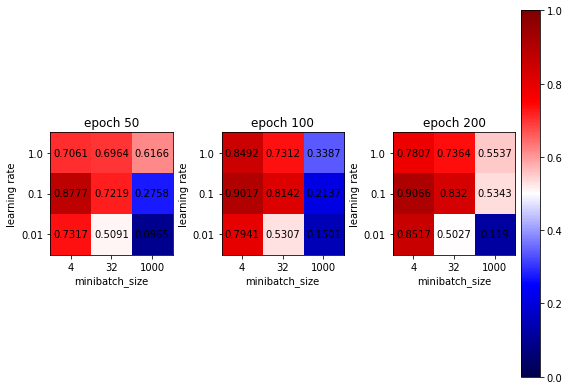

---------------------------------------------------
Acurácia -- Busca SEM auto_grad
---------------------------------------------------


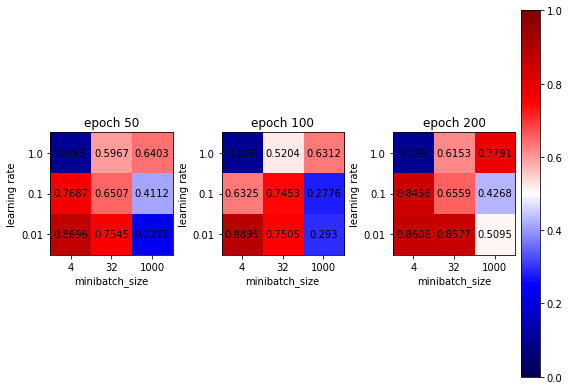

In [ ]:
    
Utils.printMessage("Acurácia -- Busca COM auto_grad")
showResults(tab_resultados)
Utils.printMessage("Acurácia -- Busca SEM auto_grad")
showResults(tab_resultados_sem_auto_grad)

---

#####**Discrepância**
Percebe-se que há uma diferença significativa entre as execuções com **auto_grad=True** e com **auto_grad=False**. Além das diferenças em valores absolutos, o comportamento em função dos hiper-parâmetros também muda, principalmente em relação à taxa de aprendizado. 

\\

As **diferenças absolutas** entre os cálculos devem-se, provavelmente, a um tratamento melhor do código do pytorch em relação à estabilidade numérica. Dessa forma, ao longo de diversas iterações, as pequenas variações numéricas se acumulam e os resultados finais variam.

\\

Para avaliar melhor esta discrepância no comportamento em relação à **taxa de aprendizado**, foi feito um teste: calcularam-se os gradientes pelos dois métodos simultaneamente e percebeu-se que os gradientes são idênticos a menos de um fator multiplicativo de 10x:

\\

$$
\nabla^{auto\_grad=False} Err(w,b) = 10\times\nabla^{auto\_grad=True} Err(w,b)
$$

\\

Esse fator é exato e se mantém fixo ao longo de centenas de épocas. Mas o cálculo do gradiente deveria ser único, a menos de erros numéricos. 

\\

Isso leva a crer que o cálculo realizado sem pytorch pode estar desconsiderando alguma média que deveria ser realizada. A principal suspeita é de que deveria ser calculada alguma média em função da quantidade de classes de saída, que é 10.

\\

De qualquer forma, os cálculos realizados sem pytorch foram revisados, comparados com as vídeos-aula que apresentam o código-fonte base e não foi encontrado nenhum erro (o que não quer dizer que não existam).

\\

Resolveu-se, então, acrescentar mais um teste de hiper-parâmetros com a taxa de aprendizado igual a 0.001. Isso foi feito apenas para a implementação com auto_grad=False. O resultado do teste segue abaixo e ele confirma que a melhor taxa de aprendizado para o código com auto_grad=False é 0.01, pois o novo valor de 0.001 se mostrou pior.





In [ ]:
tab_resultados_sem_auto_grad = {}

e = 50; l = 1.0; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.9001117944717407, acc=0.098, tempo=235.0191605091095)

e = 50; l = 1.0; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.41665005683898926, acc=0.5967, tempo=62.8063862323761)

e = 50; l = 1.0; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.30339744687080383, acc=0.6403, tempo=40.595623254776)

e = 50; l = 0.1; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.22264543175697327, acc=0.7687, tempo=234.4763367176056)

e = 50; l = 0.1; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.16650669276714325, acc=0.6507, tempo=62.55232214927673)

e = 50; l = 0.1; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.3171577453613281, acc=0.4112, tempo=40.68881845474243)

e = 50; l = 0.01; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.029226059094071388, acc=0.8696, tempo=233.9167881011963)


e = 50; l = 0.01; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.047875866293907166, acc=0.7545, tempo=62.13549852371216)

e = 50; l = 0.01; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.7183678150177002, acc=0.2268, tempo=40.55301284790039)

e = 50; l = 0.001; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.049198564141988754, acc=0.721, tempo=335.61078333854675)

e = 50; l = 0.001; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.12329500913619995, acc=0.4144, tempo=77.53619408607483)
                         
e = 50; l = 0.001; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.9474769830703735, acc=0.1304, tempo=45.96830725669861)

e = 100; l = 1.0; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.9001117944717407, acc=0.098, tempo=466.5323429107666)

e = 100; l = 1.0; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.4574606120586395, acc=0.5204, tempo=124.66898918151855)

e = 100; l = 1.0; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.2943468987941742, acc=0.6312, tempo=81.91157817840576)

e = 100; l = 0.1; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.13590118288993835, acc=0.6325, tempo=466.9936294555664)

e = 100; l = 0.1; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.24596500396728516, acc=0.7453, tempo=124.37320518493652)

e = 100; l = 0.1; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.34281137585639954, acc=0.2776, tempo=81.16661047935486)

e = 100; l = 0.01; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.024377454072237015, acc=0.8895, tempo=466.6657621860504)

e = 100; l = 0.01; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.044286567717790604, acc=0.7505, tempo=124.48445630073547)

e = 100; l = 0.01; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.5005657076835632, acc=0.293, tempo=80.95445537567139)

e = 100; l = 0.001; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.04408295452594757, acc=0.7797, tempo=657.6447465419769)

e = 100; l = 0.001; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.07165167480707169, acc=0.5343, tempo=157.13096714019775)

e = 100; l = 0.001; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.8456923365592957, acc=0.1352, tempo=92.80142307281494)
                         
e = 200; l = 1.0; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.9001117944717407, acc=0.098, tempo=934.3639738559723)

e = 200; l = 1.0; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.3641386330127716, acc=0.6153, tempo=250.2116138935089)

e = 200; l = 1.0; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.07576242089271545, acc=0.7791, tempo=163.83364629745483)

e = 200; l = 0.1; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.16746929287910461, acc=0.8456, tempo=934.0440518856049)

e = 200; l = 0.1; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.16189947724342346, acc=0.6559, tempo=250.73585772514343)

e = 200; l = 0.1; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.28186100721359253, acc=0.4268, tempo=162.670250415802)

e = 200; l = 0.01; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.02727535180747509, acc=0.8606, tempo=931.5880832672119)

e = 200; l = 0.01; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.026347452774643898, acc=0.8577, tempo=259.1617331504822)

e = 200; l = 0.01; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.0771753266453743, acc=0.5095, tempo=164.251336336135)

e = 200; l = 0.001; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.030237995088100433, acc=0.8467, tempo=1334.9995057582855)

e = 200; l = 0.001; m = 32
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.061428748071193695, acc=0.6587, tempo=308.7629382610321)

e = 200; l = 0.001; m = 1000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.7855963110923767, acc=0.1754, tempo=184.9287121295929)



---------------------------------------------------
Acurácia -- Busca COM auto_grad
---------------------------------------------------


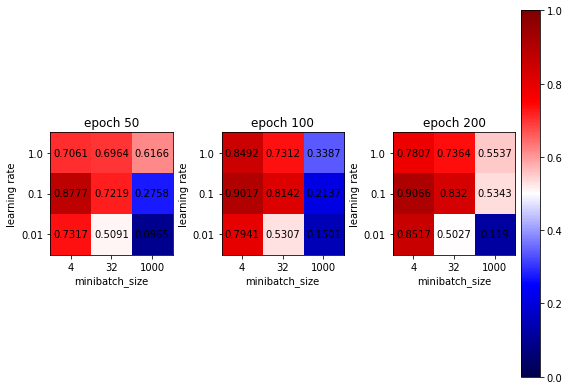

---------------------------------------------------
Acurácia -- Busca SEM auto_grad
---------------------------------------------------


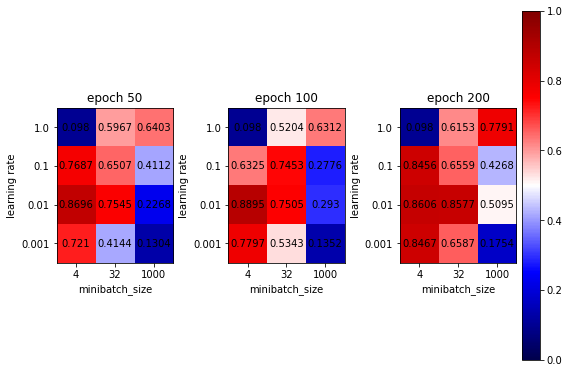

In [ ]:
Utils.printMessage("Acurácia -- Busca COM auto_grad")
showResults(tab_resultados)
Utils.printMessage("Acurácia -- Busca SEM auto_grad")
showResults(tab_resultados_sem_auto_grad)

---
#####**Escolha de hiper-parâmetros**

Em função dos resultados obtidos, escolheu-se utilizar os hiper-parâmetros que levaram ao modelo de maior acurácia, desprezando o relativo alto custo computacional para gerá-lo.

\\
**AUTO_GRAD=True**


\# |ÉPOCAS|TX. APRENDIZADO|MINIBATCH|ACURÁCIA|TEMPO (secs)
----|------|---------------|---------|--------|------------
**1**|**200** |  **0,1**   |   **4** |**0,9066**|**992**

\\

**AUTO_GRAD=False**



 \# |ÉPOCAS|TX. APRENDIZADO|MINIBATCH|ACURÁCIA|TEMPO (secs)
----|------|---------------|---------|--------|------------
**1**|**100** |  **0,01**   |   **4** |**0,8895**|**446**

---

### **Treinamento**

####**Treinamento com AUTO_GRAD=True**

Foram utilizados os melhores hiper-parâmetros, exceto a quantidade de épocas. Esta foi aumentada para 400 para ser possível avaliar se isso traria algum benefício para treinamento ou se levaria a *overfitting*. 

\\

**Relatório:**

O treinamento foi realizado e um relatório foi gerado. O relatório contém:
 - informações a respeito de cada época
   - erro
   - acurácia 
   - tempo do treinamento
   - tempo da validação
 - métricas associadas ao classificador (não serão analisadas neste trabalho)
 - matriz de confusão

\\

**Conclusões parciais:**

Além dos hiper-parâmetros utilizados (ver seção anterior), as principais métricas do treinamento estão resumidas nas tabelas abaixo:

\\

TAM. IMAGEM | NÚM. IMAGENS DE TREINO | NÚM. IMAGENS DE VALIDAÇÃO 
------------|------------------------|---------------------
28x28       |50.000                  | 10.000

\\

TEMPO TREINAMENTO (secs)    |TEMPO VALIDAÇÃO (secs)
----------------------------|--------
 4 (p/ ÉPOCA)               |  0,03 (p/ ÉPOCA)
 1.543 (TOTAL)              | 12,72 (TOTAL) 

\\

ACURÁCIA| ERRO  
--------|------
**0,90**| 0,02 

\\

Durante o treinamento são computados o erro (*loss*) sobre os dados de treinamento e a acurácia sobre os dados de validação para cada época. Essas informações são impressas ao final, como duas curvas de aprendizado complementares. Elas ajudam a entender se houve *overfitting* ou *underfitting* do modelo.

\\

Também são computados ao final do treinamento a matriz de confusão e métricas diversas do classificador. Esses valores são computados sobre os dados de validação. Posteriormente, após o treinamento, serão computados esses mesmos valores para o dado de teste.

Obs.: Apesar do código rodar em GPU, foram utilizadas apenas CPUs para a execução deste trabalho.

[ RUN ] nepochs = 400, lr = 0.1, minibatch_size = 4
---------------------------------------------------
[ INFO ] Alterando a taxa de aprendizado de 0.1 para 0.1.
---------------------------------------------------
---------------------------------------------------
[ INFO ] Alterando o tamanho do minibatch de 1 para 4.
---------------------------------------------------
---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                400
    [ LEARNING RATE ]         0.1
    [ LOSS FUNCTION ]         Minimum Square Error
    [ AUTOGRAD ]              True
    [ NÚMERO DE PARÂMETROS ]  31810
    [ DEVICE ]                cpu
    [ X LEN ]                 50000
    [ Y LEN ]                 50000
    [ MINIBATCH SIZE ]        4
[     0/  400]  [ LOSS ] 0.4214408 - [ ACC ] 0.3781000 ----- [ TOTAL TIME ] train:     4.48 secs, valid:     0.08 secs
[    26/  400]  [ LOSS ] 0.0349428 - [ ACC ] 0.8

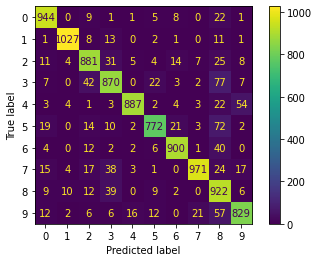

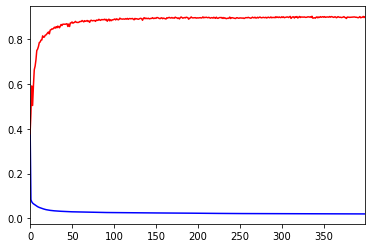

In [ ]:
report = Report(transf=transf)
mlp, loss, accuracy, t_time = runTest(400, 0.1, 4, auto_grad=True, device='cpu', show=True, verbose=True, report=report) 
report.printCurves()

####**Treinamento com AUTO_GRAD=False**

A metodologia para o treinamento com AUTO_GRAD=False foi a mesma utilizada no caso anterior. Assim, iremos diretamente para os resultados.

\\

**Conclusões parciais:**

TAM. IMAGEM | NÚM. IMAGENS DE TREINO | NÚM. IMAGENS DE VALIDAÇÃO 
------------|------------------------|---------------------
28x28       |50.000                  | 10.000

\\

TEMPO TREINAMENTO (secs)    |TEMPO VALIDAÇÃO (secs)
----------------------------|--------
 3,77 (p/ ÉPOCA)            |  0,03 (p/ ÉPOCA)
 1.442 (TOTAL)              | 12,59 (TOTAL) 

\\

ACURÁCIA| ERRO  
--------|------
**0,91**| 0,017 

\\

**Obs.: Lembrando que a acurácia está sendo medida, neste momento, apenas sobre os dados de validação.**

[ RUN ] nepochs = 400, lr = 0.01, minibatch_size = 4
---------------------------------------------------
[ INFO ] Alterando a taxa de aprendizado de 0.01 para 0.01.
---------------------------------------------------
---------------------------------------------------
[ INFO ] Alterando o tamanho do minibatch de 1 para 4.
---------------------------------------------------
---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                400
    [ LEARNING RATE ]         0.01
    [ LOSS FUNCTION ]         Minimum Square Error
    [ AUTOGRAD ]              False
    [ NÚMERO DE PARÂMETROS ]  31810
    [ DEVICE ]                cpu
    [ X LEN ]                 50000
    [ Y LEN ]                 50000
    [ MINIBATCH SIZE ]        4
[     0/  400]  [ LOSS ] 0.3727733 - [ ACC ] 0.4230000 ----- [ TOTAL TIME ] train:     4.00 secs, valid:     0.03 secs
[    26/  400]  [ LOSS ] 0.0305661 - [ ACC 

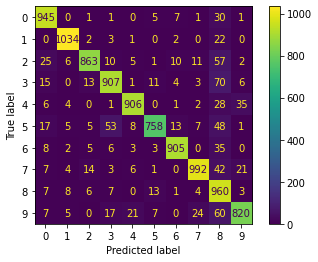

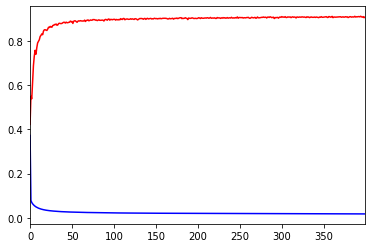

In [ ]:
report_2 = Report(transf=transf)
mlp_2, loss, accuracy, t_time = runTest(400, 0.01, 4, auto_grad=False, device='cpu', show=True, verbose=True, report=report_2) 
report_2.printCurves()

###**Teste final do classificador**

Nesta seção, será realizada a classificação sobre os dados de teste. Os resultados obtidos agora são os mais importantes, pois indicam como o classificador se comporta em dados nunca vistos anteriormente, nem durante os testes, nem durante a busca por hiper-parâmetros.

\\

**RESUMO AUTO_GRAD=True**

ACURÁCIA  | TEMPO TREINO (50.000 imgs) | TEMPO PREDIÇÃO (10.000 imgs)
----------|-----------------------|--------------------
**0,90**  |    1.936,0 secs         |   1,13 secs

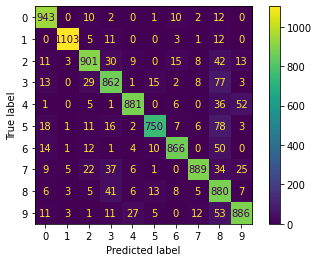

\\

**RESUMO AUTO_GRAD=False**

ACURÁCIA  | TEMPO TREINO  (50.000 imgs) | TEMPO PREDIÇÃO (10.000 imgs)
----------|-----------------------|--------------------
**0,91**  |    1.558,0 secs         |   1,31 secs


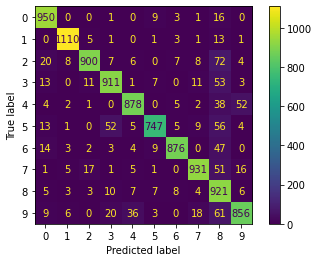


              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       980
         1.0       0.99      0.97      0.98      1135
         2.0       0.90      0.87      0.89      1032
         3.0       0.85      0.85      0.85      1010
         4.0       0.94      0.90      0.92       982
         5.0       0.94      0.84      0.89       892
         6.0       0.94      0.90      0.92       958
         7.0       0.95      0.86      0.91      1028
         8.0       0.69      0.90      0.78       974
         9.0       0.90      0.88      0.89      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.90      0.90     10000



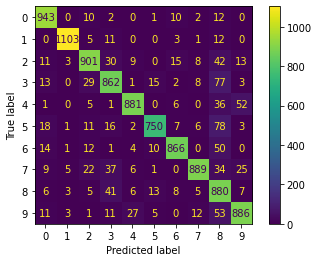

--- PREDIZENDO COM DADOS NUNCA VISTOS ---
---------- AUTO_GRAD=True ---------------
Tempo de predição: 1.1348671913146973
tensor([[-2.7482e-02,  3.2463e-02,  1.0367e-02,  ..., -4.0082e-03,
          1.3574e-02,  5.5987e-02],
        [ 2.5579e-03,  2.6439e-03,  9.8238e-01,  ..., -4.0661e-03,
         -1.2394e-02, -3.6815e-03],
        [ 5.6372e-02,  7.8188e-01,  7.3878e-03,  ...,  6.7697e-03,
         -4.8789e-04,  1.5950e-02],
        ...,
        [ 9.8345e-01,  3.1309e-02, -1.2565e-02,  ...,  5.4878e-02,
         -1.5211e-03,  3.3324e-03],
        [ 1.0482e-02, -2.2943e-03,  1.4352e-02,  ...,  2.9255e-02,
          1.3538e-01,  1.2560e-02],
        [-2.6344e-02, -5.4668e-02, -3.4328e-02,  ...,  1.8458e-03,
         -4.9617e-03, -3.4779e-02]], grad_fn=<TanhBackward0>)


In [ ]:

t1 = time.time()
y_pred = mlp.predict(x_test)
report = Report(transf=transf)
accuracy = report.do(torch.from_numpy(y_test), y_pred, 1, torch.tensor(0), show=True)
t2 = time.time()
print(f"--- PREDIZENDO COM DADOS NUNCA VISTOS ---")
print(f"---------- AUTO_GRAD=True ---------------")
print(f"Tempo de predição: {t2-t1}")
# para salvar os valores
print(y_pred)



              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95       980
         1.0       0.98      0.98      0.98      1135
         2.0       0.96      0.87      0.91      1032
         3.0       0.91      0.90      0.90      1010
         4.0       0.93      0.89      0.91       982
         5.0       0.95      0.84      0.89       892
         6.0       0.97      0.91      0.94       958
         7.0       0.95      0.91      0.92      1028
         8.0       0.69      0.95      0.80       974
         9.0       0.91      0.85      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



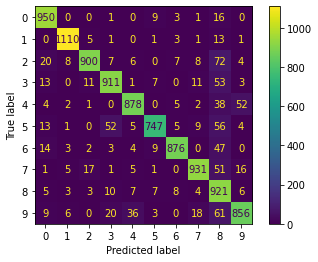

--- PREDIZENDO COM DADOS NUNCA VISTOS ---
---------- AUTO_GRAD=False --------------
Tempo de predição: 1.317819356918335
tensor([[-3.1599e-02,  2.3947e-01, -4.9154e-03,  ..., -6.6703e-03,
         -1.9593e-01,  1.3314e-02],
        [-9.2448e-03, -1.8018e-04,  9.7620e-01,  ...,  4.4643e-03,
         -1.3478e-02, -8.2753e-03],
        [ 5.1128e-03,  9.1080e-01, -1.0094e-02,  ..., -2.2219e-02,
         -1.8044e-03, -2.4351e-02],
        ...,
        [ 9.7236e-01, -1.4667e-02, -1.3529e-02,  ...,  1.5210e-02,
          6.2027e-02, -1.5599e-02],
        [ 9.7061e-02,  3.2828e-03,  1.1377e-01,  ...,  1.2295e-01,
          3.6821e-01,  8.1655e-02],
        [-6.8454e-03,  1.0609e-03, -4.3518e-03,  ..., -1.6350e-02,
          7.1496e-02,  1.8520e-03]])


In [ ]:

t1 = time.time()
y_pred_2 = mlp_2.predict(x_test)
report = Report(transf=transf)
accuracy = report.do(torch.from_numpy(y_test), y_pred_2, 1, torch.tensor(0), show=True)
t2 = time.time()
print(f"--- PREDIZENDO COM DADOS NUNCA VISTOS ---")
print(f"---------- AUTO_GRAD=False --------------")
print(f"Tempo de predição: {t2-t1}")

# para salvar os valores
print(y_pred_2)


### **Comparação batch, minibatch e estocástico**

\\

TAMANHO DO MINIBATCH |  TIPO DE TREINAMENTO
---------------------|------------------------------
                1    | Stochastic Gradient Descent 
                n    | Batch 
    1 < tam < n      | Mini-batch




In [ ]:
# OBSERVAÇÃO:
#
# Esta célula implementa a busca por hiper-parâmetros.
# Por isso, os resultados parciais eram salvos a cada teste realizado.
#

vepochs=np.array([50, 100])
vlr=np.array([0.1, 0.01] )
vmini=np.array([1, 4, 50000])


#runSuite(vepochs, vlr, vmini, auto_grad=True, show=False, verbose=False, device='cpu', code=True)

print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")

runSuite(vepochs, vlr, vmini, auto_grad=False, show=False, verbose=False, device='cpu', code=True)



[ INFO ] Qtd. de testes: 12
[ RUN ] nepochs = 50, lr = 0.1, minibatch_size = 1
[ BEST ACCURACY ]  {'loss': 0.02416078932583332, 'acc': 0.8981, 'tempo': 838.9536063671112, 'epoch': 50, 'lr': 0.1, 'mini': 1}
[ 0 ] loss=0.02416078932583332, acc=0.8981, tempo treinamento=838.9536063671112 secs
[ CODE ] e = 50; l = 0.1; m = 1
[ CODE ] insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.02416078932583332, acc=0.8981, tempo=838.9536063671112)
[ RUN ] nepochs = 50, lr = 0.1, minibatch_size = 4
[ 1 ] loss=0.022730497643351555, acc=0.8921, tempo treinamento=236.345801115036 secs
[ CODE ] e = 50; l = 0.1; m = 4
[ CODE ] insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.022730497643351555, acc=0.8921, tempo=236.345801115036)
[ RUN ] nepochs = 50, lr = 0.1, minibatch_size = 50000
[ 2 ] loss=1.012786865234375, acc=0.0873, tempo treinamento=32.472145557403564 secs
[ CODE ] e = 50; l = 0.1; m = 50000
[ CODE ] insere_elemento(tab_resultados, e=e, l=l, m=m, loss=1.012786865234375, acc=0.0873, temp

{50: {0.1: {1: [0.8978230953216553, 0.0991, 674.9800837039948],
   4: [0.17775698006153107, 0.7096, 227.55785584449768],
   50000: [0.8747369647026062, 0.1102, 39.31229043006897]},
  0.01: {1: [0.026335831731557846, 0.8922, 674.6250417232513],
   4: [0.03447936102747917, 0.8059, 227.79943823814392],
   50000: [0.9639650583267212, 0.1065, 38.92189598083496]}},
 100: {0.1: {1: [0.8943617939949036, 0.0992, 1348.4670522212982],
   4: [0.20186245441436768, 0.6753, 456.48039388656616],
   50000: [0.8500286936759949, 0.1356, 77.69254398345947]},
  0.01: {1: [0.02172522246837616, 0.8998, 1351.012391090393],
   4: [0.019704891368746758, 0.8954, 456.10730147361755],
   50000: [1.0017215013504028, 0.1063, 76.95061945915222]}}}

#### **Restaurando dados do treinamento**


In [ ]:


tab_resultados = {}
e = 50; l = 0.1; m = 1
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.02416078932583332, acc=0.8981, tempo=838.9536063671112)
e = 50; l = 0.1; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.022730497643351555, acc=0.8921, tempo=236.345801115036)
e = 50; l = 0.1; m = 50000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=1.012786865234375, acc=0.0873, tempo=32.472145557403564)
e = 50; l = 0.01; m = 1
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.04025046527385712, acc=0.7143, tempo=819.3137111663818)
e = 50; l = 0.01; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.0569395050406456, acc=0.7007, tempo=240.38638854026794)
e = 50; l = 0.01; m = 50000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.963198721408844, acc=0.1279, tempo=32.322216510772705)
e = 100; l = 0.1; m = 1
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.025411298498511314, acc=0.8979, tempo=1626.7290480136871)
e = 100; l = 0.1; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.021547462791204453, acc=0.8977, tempo=475.86452865600586)
e = 100; l = 0.1; m = 50000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.9228023886680603, acc=0.1184, tempo=63.73387050628662)
e = 100; l = 0.01; m = 1
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.03770865127444267, acc=0.7838, tempo=1621.8509757518768)
e = 100; l = 0.01; m = 4
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=0.04590868204832077, acc=0.6715, tempo=475.69951915740967)
e = 100; l = 0.01; m = 50000
insere_elemento(tab_resultados, e=e, l=l, m=m, loss=1.0250951051712036, acc=0.1189, tempo=64.04694628715515)


In [ ]:
tab_resultados_sem_auto_grad = {}

e = 50; l = 0.1; m = 1
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.8978230953216553, acc=0.0991, tempo=674.9800837039948)
e = 50; l = 0.1; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.17775698006153107, acc=0.7096, tempo=227.55785584449768)
e = 50; l = 0.1; m = 50000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.8747369647026062, acc=0.1102, tempo=39.31229043006897)
e = 50; l = 0.01; m = 1
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.026335831731557846, acc=0.8922, tempo=674.6250417232513)
e = 50; l = 0.01; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.03447936102747917, acc=0.8059, tempo=227.79943823814392)
e = 50; l = 0.01; m = 50000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.9639650583267212, acc=0.1065, tempo=38.92189598083496)
e = 100; l = 0.1; m = 1
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.8943617939949036, acc=0.0992, tempo=1348.4670522212982)
e = 100; l = 0.1; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.20186245441436768, acc=0.6753, tempo=456.48039388656616)
e = 100; l = 0.1; m = 50000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.8500286936759949, acc=0.1356, tempo=77.69254398345947)
e = 100; l = 0.01; m = 1
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.02172522246837616, acc=0.8998, tempo=1351.012391090393)
e = 100; l = 0.01; m = 4
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=0.019704891368746758, acc=0.8954, tempo=456.10730147361755)
e = 100; l = 0.01; m = 50000
insere_elemento(tab_resultados_sem_auto_grad, e=e, l=l, m=m, loss=1.0017215013504028, acc=0.1063, tempo=76.95061945915222)



---

#####**Visualizando os resultados**

**AUTO_GRAD=True**

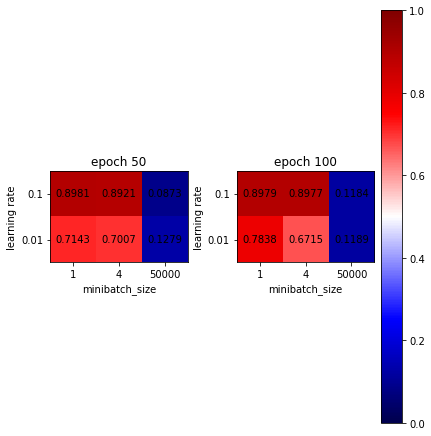

Na busca **com auto_grad**, como era esperado, os melhores resultados de acurácia foram obtidos com taxa de aprendizado igual a 0.1 (de acordo com a busca no espaço de hiper-parâmetros realizada anteriormente). 

\\

A tabela abaixo mostra os valores obtidos para cada opção de treinamento:

\\

 Estratégia |ÉPOCAS|ACURÁCIA|TEMPO (secs)
------------|------|--------|---------
Stochastic  | 50   | 0,8981 | 839,0 
Minibatch   | 100  | 0,8977 | 475,0
Batch       | 50   | 0,1279 | 32,0

\\



**AUTO_GRAD=False**


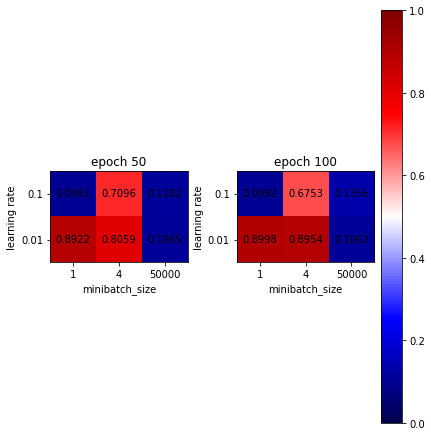

Na busca **sem auto_grad**, os melhores resultados foram obtidos com taxa de aprendizado igual a 0,01 (também de acordo com a busca de hiper-parâmetros realizada anteriormente).

\\

A tabela abaixo mostra os valores obtidos para cada opção de treinamento:

\\


 Estratégia |ÉPOCAS|ACURÁCIA|TEMPO (secs)
------------|------|--------|---------
Stochastic  | 100  | 0,8998 | 1.351,0
Minibatch   | 100  | 0,8954 |  456,0
Batch       | 100  | 0,1356 |    77,0

\\

--- 

#### **Conclusões**

\\

A literatura diz que a estratégia estocástica tende a fazer um caminhamento pelo espaço de parâmetros com **menos tendência a ficar preso em um mínimo local**. Dessa forma, seria também **menos sensível à inicialização aleatória dos pesos da rede** no início do treinamento.Além disso, tende a **convergir com um número menor de épocas**. 

\\

Os experimentos aqui realizados não permitem corroborar essas afirmações. Seriam necessárias mais informações sobre cada treinamento. E, talvez, mais experimentos.

\\

Mas, quando comparamos os dois extremos, o caso estocástico e o caso batch, podemos perceber que o batch não converge com os hiper-parâmetros utilizados. Talvez, fossem necessárias mais épocas para que isso ocorresse. E, ainda assim, ele poderia convergir para um mínimo local e nunca atingir a melhor acurácia possível.

\\

Por outro lado, o tempo de processamento de uma época no estocástico é cerca foi cerca de 17x maior do que o tempo de processamento de uma época no batch. Isso leva a crer que poderiam ser realizadas 17x mais épocas no batch para se ter o mesmo custo de processamento no treinamento. Novos experimentos seriam necessários para analisar essa possibilidade.

\\

Em relação ao custo computacional, além do processamento temos também o custo de armazenamento. Não é o caso desse teste sobre o MNIST, mas em muitos casos reais não é possível realizar treinamento batch sobre todos os dados de treinamento simultaneamente, pois a quantidade de memória rápida não é suficiente.

\\

Por fim, podemos perceber pelos testes que a estratégia minibatch reune as boas características de cada uma das outras estratégias: 
 - custo de processamento próximo ao batch;
 - custo de armazenamento próximo ao batch;
 - acurácia próxima ao estocástico;  
 - quantidade de épocas para convergir próxima ao estocástico.

---------------------------------------------------
Acurácia -- Busca COM auto_grad
---------------------------------------------------


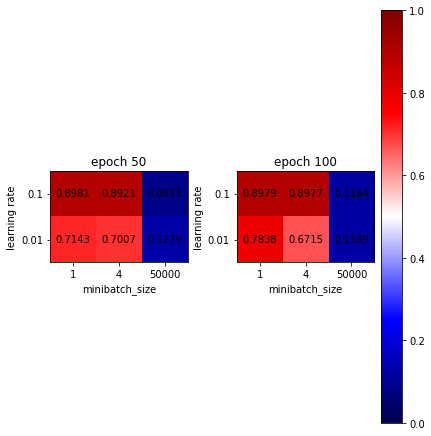

---------------------------------------------------
Acurácia -- Busca SEM auto_grad
---------------------------------------------------


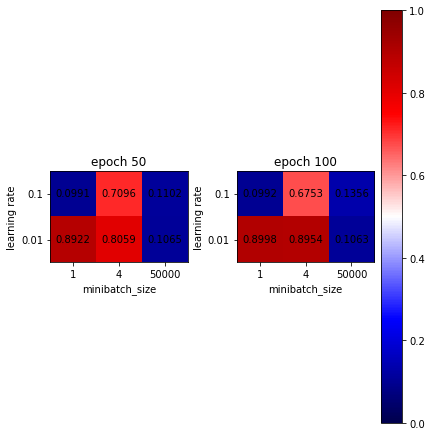

In [ ]:
    
Utils.printMessage("Acurácia -- Busca COM auto_grad")
showResults(tab_resultados)
Utils.printMessage("Acurácia -- Busca SEM auto_grad")
showResults(tab_resultados_sem_auto_grad)

---

## **ANEXO: Voltando à discrepância no cálculo do gradiente**

Discutiu-se em aula sobre a questão do fator de 10x entre os valores do gradiente do auto_grad e do gradiente calculado internamente.

\\

Reavaliamos o código, entendemos a causa dessa discrepância: havia uma incompatibilidade entre os cálculos que geravam o erro e os cálculos que geravam o gradiente do erro. Isso acontecia no caso auto_grad=False. 

\\

Entretanto, essa incompatibilidade não afeta em nada a capacidade da rede gerada. Apenas, como visto anteriormente, a taxa de aprendizado utilizada para cada um dos casos deveria ter um fator de 10x também. Situação esta que a busca por hiper-parâmetros conseguiu identificar.

\\

Dessa forma, o trabalho aqui realizado e as análises continuam válidas.

\\

De qualquer forma, essa icompatibilidade foi corrigida, gerando um nova classe que implementa a classe base Loss.

\\

Abaixo, seguem as duas classes. MSE é a classe utilizada que foi utilizada para todas as análises anteriores do trabalho (com a incompatibilidade).

\\

```python
class MSE(Loss):
  def __init__(self):
    super().__init__()

  def err(self, y_true, y_pred):
    #print(f"shape y_true = {y_true.shape} -- shape y_pred = {y_pred.shape}")
    return torch.mean(torch.pow(y_true - y_pred, 2))

  def err_der(self, y_true, y_pred):
    return ( 2 * (y_pred - y_true) ) / y_true.shape[0]

```

\\

E MSE_2 é a nova classe que corrige a incompatibilidade.

\\

```python
class MSE_2(Loss):
  def __init__(self):
    super().__init__()

  def err(self, y_true, y_pred):
    return torch.mean(torch.pow(y_true - y_pred, 2))

  def err_der(self, y_true, y_pred):
    return ( 2 * (y_pred - y_true) ) / *(y_true.shape[0]*y_true.shape[1])
```

\\

A correção da incompatibilidade foi realizada no método **err_der**.

\\

Agora, somente para validar essa correção. Serão regerados os treinamentos, tanto de auto_grad=True quanto de auto_grad=False, mas serão utilizados apenas  os hiper-parâmetros selecionados anteriormente para o caso auto_grad=True. 

\\

Espera-se que, agora, as duas redes convirjam com o mesmo valor de taxa de aprendizado em 0,1.

\\

Isso será mostrado na célula de execução abaixo.



---------------------------------------------------------
--------------------- AUTO_GRAD=True --------------------
---------------------------------------------------------

---------------------------------------------------
[ INFO ] Alterando a taxa de aprendizado de 0.1 para 0.1.
---------------------------------------------------
---------------------------------------------------
[ INFO ] Alterando o tamanho do minibatch de 1 para 4.
---------------------------------------------------
---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                200
    [ LEARNING RATE ]         0.1
    [ LOSS FUNCTION ]         Minimum Square Error - 2
    [ AUTOGRAD ]              True
    [ NÚMERO DE PARÂMETROS ]  31810
    [ DEVICE ]                cpu
    [ X LEN ]                 50000
    [ Y LEN ]                 50000
    [ MINIBATCH SIZE ]        4
[     0/  200]  [ LOSS ] 0.4456006 - [ A

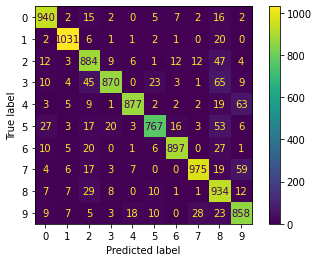

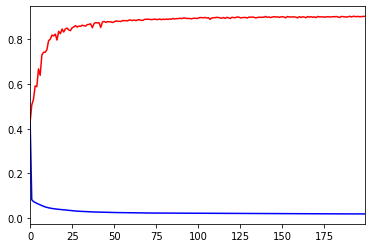

In [ ]:
print("---------------------------------------------------------")
print("--------------------- AUTO_GRAD=True --------------------")
print("---------------------------------------------------------")
print("")
report = Report(transf=transf)
loss=MSE_2()
mlp = buildMLP_MNIST_1CamadaOculta(nw=40, epochs=200, lr=0.1, auto_grad=True, report=report, show=True, device='cpu', loss=loss)
loss, accuracy, t_time = mlp.fit(x_train, y_train, x_valid, y_valid, lr=0.1, minibatch_size=4, verbose=True)
report.printCurves()

---------------------------------------------------------
--------------------- AUTO_GRAD=False -------------------
---------------------------------------------------------

---------------------------------------------------
[ INFO ] Alterando a taxa de aprendizado de 0.1 para 0.1.
---------------------------------------------------
---------------------------------------------------
[ INFO ] Alterando o tamanho do minibatch de 1 para 4.
---------------------------------------------------
---------------------------------------------------
[[ INICIANDO TREINAMENTO ]]
---------------------------------------------------
    [ EPOCHS ]                200
    [ LEARNING RATE ]         0.1
    [ LOSS FUNCTION ]         Minimum Square Error - 2
    [ AUTOGRAD ]              False
    [ NÚMERO DE PARÂMETROS ]  31810
    [ DEVICE ]                cpu
    [ X LEN ]                 50000
    [ Y LEN ]                 50000
    [ MINIBATCH SIZE ]        4
[     0/  200]  [ LOSS ] 0.3902353 - [ 

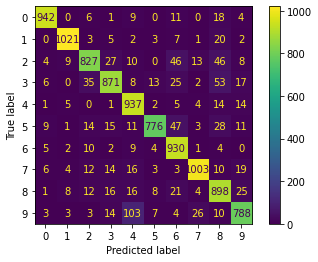

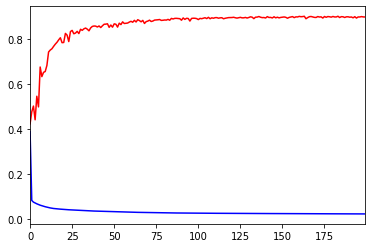

In [ ]:
print("---------------------------------------------------------")
print("--------------------- AUTO_GRAD=False -------------------")
print("---------------------------------------------------------")
print("")
report = Report(transf=transf)
loss=MSE_2()
mlp = buildMLP_MNIST_1CamadaOculta(nw=40, epochs=200, lr=0.1, auto_grad=False, report=report, show=True, device='cpu', loss=loss)
loss, accuracy, t_time = mlp.fit(x_train, y_train, x_valid, y_valid, lr=0.1, minibatch_size=4, verbose=True)
report.printCurves()
